In [12]:
import os 
import zipfile 

import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torchvision
import torchvision.transforms as transforms

import glob
from PIL import Image

from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from IPython.display import clear_output
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
import seaborn as sns

from keras import backend as K

from sklearn.utils import resample

In [13]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [14]:
# data_dir = "images/"
# metadata_path = "HAM10000_metadata.csv"
data_dir = "/content/drive/MyDrive/Colab Notebooks/images/"
metadata_path = "/content/drive/MyDrive/Colab Notebooks/HAM10000_metadata.csv"

In [15]:
#Lesion Dictionary
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [16]:
# Read metadata into dataframe
metadata = pd.read_csv(metadata_path)
skin_df = metadata

In [17]:
# Dictionary for Image Names
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob.glob(os.path.join(data_dir, '*.jpg'))}

In [18]:
#Create useful Columns - Images Path, Lesion Type and Lesion Categorical Code
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [19]:
# Lesion code dictionary
lesion_code_dict = pd.Series(skin_df.dx.values,index=skin_df.cell_type_idx).to_dict()

lesion_code_dict

{0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'nv', 5: 'mel', 6: 'vasc'}

In [20]:
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Colab Notebooks/images/...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Colab Notebooks/images/...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Colab Notebooks/images/...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Colab Notebooks/images/...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,/content/drive/MyDrive/Colab Notebooks/images/...,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,/content/drive/MyDrive/Colab Notebooks/images/...,Actinic keratoses,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,/content/drive/MyDrive/Colab Notebooks/images/...,Actinic keratoses,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,/content/drive/MyDrive/Colab Notebooks/images/...,Actinic keratoses,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,/content/drive/MyDrive/Colab Notebooks/images/...,Actinic keratoses,0


In [21]:
# Attach images to the skin_df Dataframe
temp_arr, count = [], 0
for path in tqdm(skin_df['path']):
  temp_arr.append(np.asarray( Image.open(path).resize((100,75)) ))
  count += 1
  # print(f"Processed images: {count}")
  # if count % 10 == 0: clear_output()

skin_df['image'] = temp_arr


# skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

100%|██████████| 10015/10015 [02:19<00:00, 71.85it/s]


In [23]:
# Separate the dataframe into Features and Targets data
features = skin_df.drop(columns=['cell_type_idx','dx'],axis=1)
target = skin_df['cell_type_idx']

In [24]:
# Create First Train and Test sets
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20, random_state=1)
print(x_train_o.shape)
print(y_train_o.shape)

(8012, 10)
(8012,)


In [25]:
# Create image arrays from the train and test sets
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

print(x_train.shape)
print(x_test.shape)

(8012, 75, 100, 3)
(2003, 75, 100, 3)


In [26]:
# Class distribution before data augmentation
train_value_counts = y_train_o.value_counts()
print(train_value_counts)
print(f'Total images: {train_value_counts.sum()}')

4    5378
5     891
2     871
1     418
0     266
6     110
3      78
Name: cell_type_idx, dtype: int64
Total images: 8012


In [27]:
# Data Augmentation
# Image data generator is used to generate the possible versions of data as given below.

dataaugment = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range = 10
    ) 

In [28]:
# For each lesion code != 4, get the indices in y_train_o.
# For the same indices in x_train_o, augment the image present in the row.
reset_y_train_o = y_train_o.reset_index(drop=True)
reset_index = reset_y_train_o.index

print(len(y_train_o))

8012


In [29]:
# The normalisation is done using the training set Mean and Std. Deviation as reference
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std

In [30]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [31]:
# Splitting training into Train and Validatation sets
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state=1)

# Reshaping the Images into 3 channels (RGB)
# height = 75, width = 100, canal = 3
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [32]:
from keras.layers import Concatenate, AveragePooling2D

input_shape = (75, 100, 3)
num_classes = 7

# GoogleNet

def inception(x, filters):
    # 1x1
    path1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)

    # 1x1->3x3
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    
    # 1x1->5x5
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)

    # 3x3->1x1
    path4 = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)

    return Concatenate(axis=-1)([path1,path2,path3,path4])


def auxiliary(x, name=None):
    layer = AveragePooling2D(pool_size=(5,5), strides=3, padding='valid')(x)
    layer = Conv2D(filters=128, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Flatten()(layer)
    layer = Dense(units=256, activation='relu')(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=num_classes, activation='softmax', name=name)(layer)
    return layer


def googlenet():
    layer_in = Input(shape=input_shape)
    
    # stage-1
    layer = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(layer_in)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = BatchNormalization()(layer)

    # stage-2
    layer = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)

    # stage-3
    layer = inception(layer, [ 64,  (96,128), (16,32), 32]) #3a
    layer = inception(layer, [128, (128,192), (32,96), 64]) #3b
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-4
    layer = inception(layer, [192,  (96,208),  (16,48),  64]) #4a
    aux1  = auxiliary(layer, name='aux1')
    layer = inception(layer, [160, (112,224),  (24,64),  64]) #4b
    layer = inception(layer, [128, (128,256),  (24,64),  64]) #4c
    layer = inception(layer, [112, (144,288),  (32,64),  64]) #4d
    aux2  = auxiliary(layer, name='aux2')
    layer = inception(layer, [256, (160,320), (32,128), 128]) #4e
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-5
    layer = inception(layer, [256, (160,320), (32,128), 128]) #5a
    layer = inception(layer, [384, (192,384), (48,128), 128]) #5b
    layer = AveragePooling2D(pool_size=(7,7), strides=1, padding='same')(layer)
    
    # stage-6
    layer = Flatten()(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=256, activation='linear')(layer)
    main = Dense(units=num_classes, activation='softmax', name='main')(layer)
    
    model = Model(inputs=layer_in, outputs=[main, aux1, aux2])
    
    return model


# train model
model = googlenet()
model.summary()
'''
optimizer = ['Adam', 'SGD', 'Adam', 'SGD']
epochs = [20, 30, 20, 30]
history_all = {}

for i in range(len(optimizer)):
    print('Usnig optimizer: ' + optimizer[i] + ', Epoch: ' + str(epochs[i]))
    
    model.compile(loss='categorical_crossentropy', 
                  loss_weights={'main': 1.0, 'aux1': 0.3, 'aux2': 0.3},
                  optimizer=optimizer[i], metrics=['accuracy'])
    
    train_history = model.fit_generator(
            train_generator,
            steps_per_epoch=EPOCH_STEPS,
            epochs=epochs[i],
            #callbacks=[checkpoint]
            shuffle=True
            )
    
    # save history    
    if len(history_all) == 0:
        history_all = {key: [] for key in train_history.history}
    
    for key in history_all:
        history_all[key].extend(train_history.history[key])

model.save(MODEL_NAME)
'''
# show train history
'''
def show_train_history(history, xlabel, ylabel, train):
    for item in train:
        plt.plot(history[item])
    plt.title('Train History')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(train, loc='upper left')
    plt.show()

show_train_history(history_all, 'Epoch', 'Accuracy', ('main_acc', 'aux1_acc', 'aux2_acc'))
show_train_history(history_all, 'Epoch', 'Loss', ('main_loss', 'aux1_loss', 'aux2_loss'))
'''

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 100, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 38, 50, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 19, 25, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 19, 25, 64)   256         max_pooling2d[0][0]              
______________________________________________________________________________________________

"\ndef show_train_history(history, xlabel, ylabel, train):\n    for item in train:\n        plt.plot(history[item])\n    plt.title('Train History')\n    plt.xlabel(xlabel)\n    plt.ylabel(ylabel)\n    plt.legend(train, loc='upper left')\n    plt.show()\n\nshow_train_history(history_all, 'Epoch', 'Accuracy', ('main_acc', 'aux1_acc', 'aux2_acc'))\nshow_train_history(history_all, 'Epoch', 'Loss', ('main_loss', 'aux1_loss', 'aux2_loss'))\n"

In [33]:
# Define metrics 

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [34]:
# New baseline
# Define the optimizer
optimizer = Adam(learning_rate=0.001, 
                 beta_1=0.9, 
                 beta_2=0.999, 
                 # epsilon=None, 
                 decay=0.0, 
                 amsgrad=False)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy", f1_m,precision_m, recall_m])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [35]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_validate = np.asarray(x_validate)
y_validate = np.asarray(y_validate)

In [36]:
# New baseline
# Fit the model
epochs = 25
batch_size = 10
history = model.fit_generator(dataaugment.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

# history = model.fit(x=x_train, y=y_train,
#                               epochs = epochs, validation_data = (x_validate,y_validate),
#                               verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
#                               , callbacks=[learning_rate_reduction])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
721/721 [==============================] - 356s 487ms/step - loss: 3.6134 - main_loss: 1.4470 - aux1_loss: 1.0677 - aux2_loss: 1.0987 - main_accuracy: 0.6465 - main_f1_m: 0.5841 - main_precision_m: 0.7218 - main_recall_m: 0.5196 - aux1_accuracy: 0.6555 - aux1_f1_m: 0.6048 - aux1_precision_m: 0.7715 - aux1_recall_m: 0.5140 - aux2_accuracy: 0.6657 - aux2_f1_m: 0.5829 - aux2_precision_m: 0.7428 - aux2_recall_m: 0.5025 - val_loss: 2.7094 - val_main_loss: 0.9215 - val_aux1_loss: 0.8808 - val_aux2_loss: 0.9072 - val_main_accuracy: 0.6808 - val_main_f1_m: 0.6994 - val_main_precision_m: 0.8205 - val_main_recall_m: 0.6142 - val_aux1_accuracy: 0.6958 - val_aux1_f1_m: 0.6782 - val_aux1_precision_m: 0.8749 - val_aux1_recall_m: 0.5577 - val_aux2_accuracy: 0.6808 - val_aux2_f1_m: 0.6989 - val_aux2_precision_m: 0.8214 - val_aux2_recall_m: 0.6130
Epoch 2/25
721/721 [==============================] - 353s 490ms/step - loss: 2.7720 - main_loss: 0.9445 - aux1_loss: 0.9006 - aux2_loss: 0.9270 -

dict_keys(['loss', 'main_loss', 'aux1_loss', 'aux2_loss', 'main_accuracy', 'main_f1_m', 'main_precision_m', 'main_recall_m', 'aux1_accuracy', 'aux1_f1_m', 'aux1_precision_m', 'aux1_recall_m', 'aux2_accuracy', 'aux2_f1_m', 'aux2_precision_m', 'aux2_recall_m', 'val_loss', 'val_main_loss', 'val_aux1_loss', 'val_aux2_loss', 'val_main_accuracy', 'val_main_f1_m', 'val_main_precision_m', 'val_main_recall_m', 'val_aux1_accuracy', 'val_aux1_f1_m', 'val_aux1_precision_m', 'val_aux1_recall_m', 'val_aux2_accuracy', 'val_aux2_f1_m', 'val_aux2_precision_m', 'val_aux2_recall_m', 'lr'])
Accuracy: 0.7482662796974182
loss: 0.6977332234382629
f1_m: 0.737145185470581
precision_m: 0.8304170966148376
recall_m: 0.6696264743804932


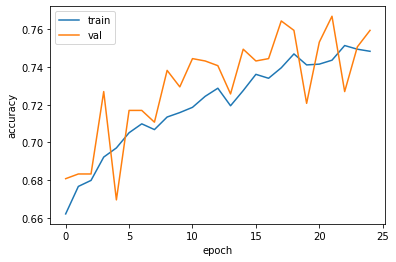

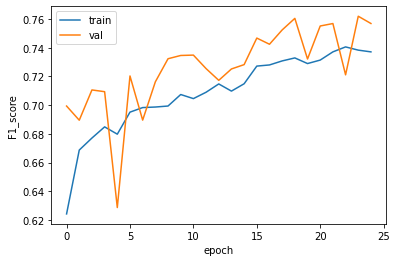

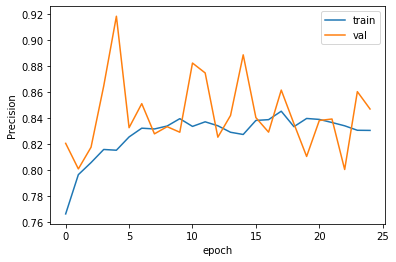

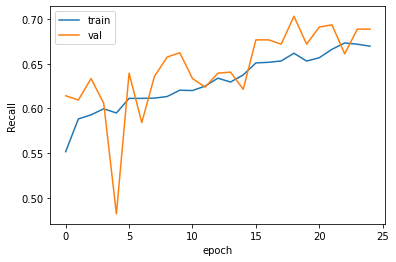

In [37]:
# plot graphs from history
print(history.history.keys())
print(f'Accuracy: {history.history["main_accuracy"][-1]}')
print(f'loss: {history.history["main_loss"][-1]}')
print(f'f1_m: {history.history["main_f1_m"][-1]}')
print(f'precision_m: {history.history["main_precision_m"][-1]}')
print(f'recall_m: {history.history["main_recall_m"][-1]}')

plt.plot(history.history["main_accuracy"], label='accuracy')
plt.plot(history.history["val_main_accuracy"], label='Validaion accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

plt.plot(history.history["main_f1_m"], label='F1_score')
plt.plot(history.history["val_main_f1_m"], label='Validaion F1_score')
plt.ylabel('F1_score')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

plt.plot(history.history["main_precision_m"], label='Precision')
plt.plot(history.history["val_main_precision_m"], label='Validaion Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

plt.plot(history.history["main_recall_m"], label='Recall')
plt.plot(history.history["val_main_recall_m"], label='Validaion Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [38]:
# Evaluate model
test_eval = model.evaluate(x_test, y_test, verbose=1, return_dict=True)
validation_eval = model.evaluate(x_validate, y_validate, verbose=1, return_dict=True)
# model.save("model.h5")

26/26 [==============================] - 6s 212ms/step - loss: 1.9209 - main_loss: 0.6786 - aux1_loss: 0.6162 - aux2_loss: 0.6262 - main_accuracy: 0.7594 - main_f1_m: 0.7569 - main_precision_m: 0.8469 - main_recall_m: 0.6887 - aux1_accuracy: 0.7743 - aux1_f1_m: 0.7600 - aux1_precision_m: 0.8701 - aux1_recall_m: 0.6791 - aux2_accuracy: 0.7693 - aux2_f1_m: 0.7587 - aux2_precision_m: 0.8723 - aux2_recall_m: 0.6767


In [39]:
for i, j in validation_eval.items():
    print(f'{i}: {j}')

loss: 1.9209141731262207
main_loss: 0.6785610914230347
aux1_loss: 0.6161662936210632
aux2_loss: 0.6261867880821228
main_accuracy: 0.7593516111373901
main_f1_m: 0.7569131255149841
main_precision_m: 0.8468733429908752
main_recall_m: 0.6887019276618958
aux1_accuracy: 0.7743142247200012
aux1_f1_m: 0.7600494027137756
aux1_precision_m: 0.8701063990592957
aux1_recall_m: 0.6790865659713745
aux2_accuracy: 0.7693266868591309
aux2_f1_m: 0.7587065100669861
aux2_precision_m: 0.8722543716430664
aux2_recall_m: 0.676682710647583


In [40]:
for i, j in test_eval.items():
    print(f'{i}: {j}')

loss: 2.0555758476257324
main_loss: 0.7274333834648132
aux1_loss: 0.6599315404891968
aux2_loss: 0.668210506439209
main_accuracy: 0.7448827028274536
main_f1_m: 0.7495604753494263
main_precision_m: 0.833039402961731
main_recall_m: 0.6838189363479614
aux1_accuracy: 0.7718422412872314
aux1_f1_m: 0.7642954587936401
aux1_precision_m: 0.8693410158157349
aux1_recall_m: 0.6856464147567749
aux2_accuracy: 0.7708437442779541
aux2_f1_m: 0.759667694568634
aux2_precision_m: 0.8628720641136169
aux2_recall_m: 0.6811821460723877


In [41]:
# Get predictions for plotting the confusion matrix
predictions = model.predict(x_test, verbose=1)

63/63 [==============================] - 14s 217ms/step


In [49]:
# Plot the confusion matrix
predictions = np.argmax(predictions, axis=0)
y_test = np.argmax(y_test, axis=0)

sns.heatmap(confusion_matrix(y_test, predictions), annot=True, cmap = 'coolwarm', fmt='.0f')
plt.show()

TypeError: ignored

# Model Parameters
input_shape = (75, 100, 3)

# Number of classes
num_classes = 7

# Optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# Epoch is number of times a node is trained
epochs = 9
batch_size = 20

# Callback functions (To follow the path of gradient descent)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=0, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=20, monitor='val_accuracy')


# dataaugment.flow(x_train,y_train, batch_size=batch_size),
# callbacks=[learning_rate_reduction,early_stopping_monitor]
history = model.fit(
    x = x_train,
    y = y_train, 
    batch_size=batch_size,
    verbose = 0, 
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=10,
    validation_data = (x_validate, y_validate)
)

loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
predictions = model.predict(x_test)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=0)
loss_t, accuracy_t = model.evaluate(x_train, y_train, verbose=0)

print("Training: accuracy = %f" % (accuracy_t))
print("Validation: accuracy = %f" % (accuracy_v))
print("Test: accuracy = %f" % (accuracy))

predictions = np.argmax(predictions, axis=1)

y_test = np.argmax(y_test, axis=1)


sns.heatmap(confusion_matrix(y_test, predictions), annot=True, cmap = 'coolwarm', fmt='.0f')
plt.show()

len(predictions)

target.value_counts()
len(x_train)
len(x_validate)